In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 디렉토리 경로
train_data_dir = './drive/MyDrive/Colab Notebooks/contest/data_outfit/train1'

# 각 폴더의 파일 목록을 반복하면서 작업
folds = os.listdir(train_data_dir)

# 데이터 파일 경로와 라벨을 저장할 리스트 생성
filepaths = []
funeral_labels = []
wedding_labels = []

# 라벨을 적합/부적합으로 수정
funeral_label_map = {
    'Funeral_Appropriate': 1,
    'Funeral_Inappropriate': 0,
    'Wedding_Appropriate': -1,
    'Wedding_Inappropriate': -1,
}
wedding_label_map = {
    'Funeral_Appropriate': -1,
    'Funeral_Inappropriate': -1,
    'Wedding_Appropriate': 1,
    'Wedding_Inappropriate': 0,
}

for fold in folds:
    if fold == '.DS_Store':
        continue  # ".DS_Store" 파일인 경우 건너뜀

    foldpath = os.path.join(train_data_dir, fold)  # 수정된 경로 설정
    for file in os.listdir(foldpath):
        filepath = os.path.join(foldpath, file)
        filepaths.append(filepath)
        funeral_labels.append(funeral_label_map.get(fold, -1))  # -1은 장례식과 관련 없는 경우
        wedding_labels.append(wedding_label_map.get(fold, -1))  # -1은 결혼식과 관련 없는 경우

In [4]:
# 데이터프레임 생성
data = pd.DataFrame({'filepaths': filepaths, 'funeral_labels': funeral_labels, 'wedding_labels': wedding_labels})

# 데이터프레임 확인
print("Data head:\n", data.head())
print("Total data count: ", len(data))

# 장례식 데이터프레임 생성
funeral_data = data[data['funeral_labels'] != -1]
wedding_data = data[data['wedding_labels'] != -1]

# 데이터프레임이 비어있는지 확인
print("Funeral data count: ", len(funeral_data))
print("Wedding data count: ", len(wedding_data))

if len(funeral_data) == 0:
    raise ValueError("No funeral data found. Please check the dataset.")
if len(wedding_data) == 0:
    raise ValueError("No wedding data found. Please check the dataset.")

# 장례식 데이터셋 분리
funeral_train_df, funeral_val_df = train_test_split(funeral_data, test_size=0.2, stratify=funeral_data['funeral_labels'], random_state=42)

# 결혼식 데이터셋 분리
wedding_train_df, wedding_val_df = train_test_split(wedding_data, test_size=0.2, stratify=wedding_data['wedding_labels'], random_state=42)

# 라벨을 문자열로 변환
funeral_train_df['funeral_labels'] = funeral_train_df['funeral_labels'].astype(str)
funeral_val_df['funeral_labels'] = funeral_val_df['funeral_labels'].astype(str)
wedding_train_df['wedding_labels'] = wedding_train_df['wedding_labels'].astype(str)
wedding_val_df['wedding_labels'] = wedding_val_df['wedding_labels'].astype(str)

Data head:
                                            filepaths  funeral_labels  \
0  ./drive/MyDrive/Colab Notebooks/contest/data_o...               1   
1  ./drive/MyDrive/Colab Notebooks/contest/data_o...               1   
2  ./drive/MyDrive/Colab Notebooks/contest/data_o...               1   
3  ./drive/MyDrive/Colab Notebooks/contest/data_o...               1   
4  ./drive/MyDrive/Colab Notebooks/contest/data_o...               1   

   wedding_labels  
0              -1  
1              -1  
2              -1  
3              -1  
4              -1  
Total data count:  317
Funeral data count:  174
Wedding data count:  143


In [5]:
# 이미지 데이터 제너레이터
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# 장례식 데이터 제너레이터
funeral_train_generator = train_datagen.flow_from_dataframe(funeral_train_df, x_col='filepaths', y_col='funeral_labels', target_size=(150, 150), batch_size=32, class_mode='binary')
funeral_val_generator = val_datagen.flow_from_dataframe(funeral_val_df, x_col='filepaths', y_col='funeral_labels', target_size=(150, 150), batch_size=32, class_mode='binary')

# 결혼식 데이터 제너레이터
wedding_train_generator = train_datagen.flow_from_dataframe(wedding_train_df, x_col='filepaths', y_col='wedding_labels', target_size=(150, 150), batch_size=32, class_mode='binary')
wedding_val_generator = val_datagen.flow_from_dataframe(wedding_val_df, x_col='filepaths', y_col='wedding_labels', target_size=(150, 150), batch_size=32, class_mode='binary')

Found 139 validated image filenames belonging to 2 classes.
Found 35 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 29 validated image filenames belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential([
        Input(shape=(150, 150, 3)),  # 첫 번째 레이어로 Input 객체 사용
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# 장례식 모델 학습
funeral_model = create_model()
funeral_history = funeral_model.fit(funeral_train_generator, epochs=10, validation_data=funeral_val_generator)

# 결혼식 모델 학습
wedding_model = create_model()
wedding_history = wedding_model.fit(wedding_train_generator, epochs=10, validation_data=wedding_val_generator)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6198 - loss: 1.4219 - val_accuracy: 0.7429 - val_loss: 0.4389
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7518 - loss: 0.4573 - val_accuracy: 0.8857 - val_loss: 0.4368
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9445 - loss: 0.3396 - val_accuracy: 0.9429 - val_loss: 0.2017
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9710 - loss: 0.1328 - val_accuracy: 0.9429 - val_loss: 0.1625
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9651 - loss: 0.0887 - val_accuracy: 0.9714 - val_loss: 0.1371
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9976 - loss: 0.0490 - val_accuracy: 0.9429 - val_loss: 0.1938
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.9429 - val_loss: 0.2343
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9946 - loss: 0.0283 - val_accuracy: 0.9714 - val_loss: 0.1498
Epoch 9/10


In [11]:
# 평가
funeral_val_loss, funeral_val_acc = funeral_model.evaluate(funeral_val_generator)
print(f'Funeral Validation accuracy: {funeral_val_acc:.2f}')
wedding_val_loss, wedding_val_acc = wedding_model.evaluate(wedding_val_generator)
print(f'Wedding Validation accuracy: {wedding_val_acc:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9705 - loss: 0.1424
Funeral Validation accuracy: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step - accuracy: 0.7931 - loss: 0.5443
Wedding Validation accuracy: 0.79


In [12]:
# 혼동 행렬과 분류 보고서 출력
funeral_val_preds = funeral_model.predict(funeral_val_generator)
funeral_val_preds_classes = (funeral_val_preds > 0.5).astype('int32')
funeral_true_classes = funeral_val_generator.classes

wedding_val_preds = wedding_model.predict(wedding_val_generator)
wedding_val_preds_classes = (wedding_val_preds > 0.5).astype('int32')
wedding_true_classes = wedding_val_generator.classes

print("Funeral Confusion Matrix")
print(confusion_matrix(funeral_true_classes, funeral_val_preds_classes))
print(classification_report(funeral_true_classes, funeral_val_preds_classes, target_names=['Inappropriate', 'Appropriate']))

print("Wedding Confusion Matrix")
print(confusion_matrix(wedding_true_classes, wedding_val_preds_classes))
print(classification_report(wedding_true_classes, wedding_val_preds_classes, target_names=['Inappropriate', 'Appropriate']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Funeral Confusion Matrix
[[20  6]
 [ 5  4]]
               precision    recall  f1-score   support

Inappropriate       0.80      0.77      0.78        26
  Appropriate       0.40      0.44      0.42         9

     accuracy                           0.69        35
    macro avg       0.60      0.61      0.60        35
 weighted avg       0.70      0.69      0.69        35

Wedding Confusion Matrix
[[12  5]
 [ 9  3]]
               precision    recall  f1-score   support

Inappropriate       0.57      0.71      0.63        17
  Appropriate       0.38      0.25      0.30        12

     accuracy                           0.52        29
    macro avg       0.47      0.48      0.47        29
 weighted avg       0.49      0.52      0.49        29



In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 새로운 이미지 파일 경로 리스트
new_image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/1.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/2.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/3.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/4.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/5.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/6.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/7.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/8.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/9.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/11.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/12.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/13.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/14.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/15.JPG',
    '/content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/16.JPG'
]
# 경로가 올바른지 확인
for img_path in new_image_paths:
    if not os.path.exists(img_path):
        print(f'File does not exist: {img_path}')
    else:
        print(f'File exists: {img_path}')

File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/1.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/2.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/3.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/4.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/5.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/6.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/7.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/8.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/9.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/11.JPG
File exists: /content/drive/MyDrive/Colab Notebooks/contest/data_outfit/new_images/12.JPG
File exists: /conte

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


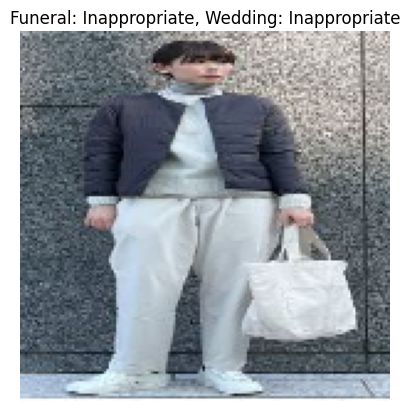

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


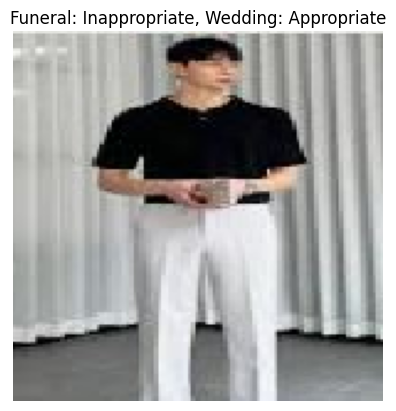

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


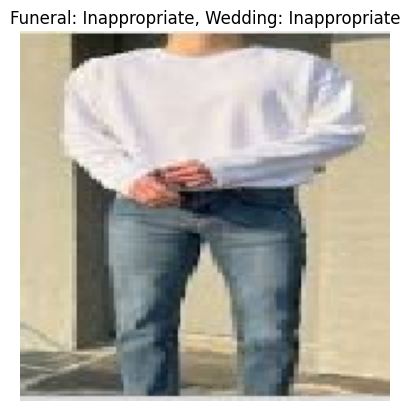

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


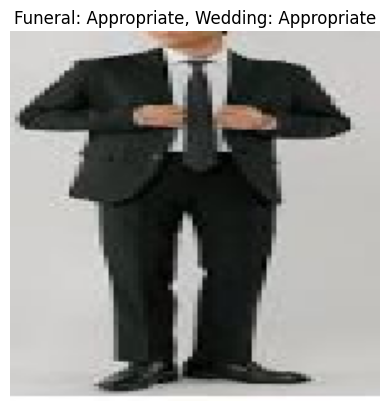

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


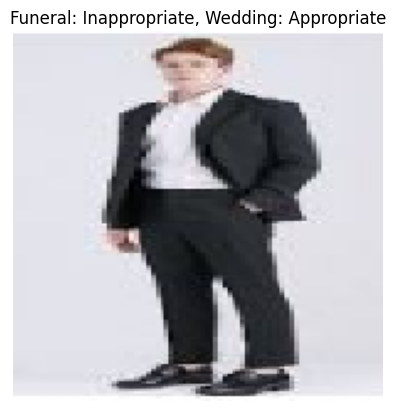

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


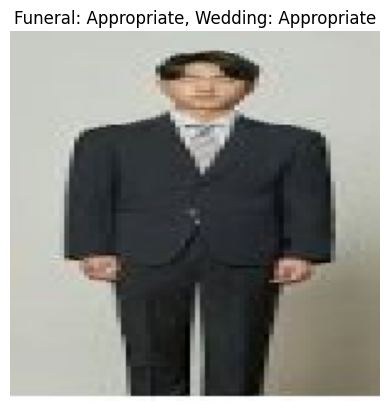

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


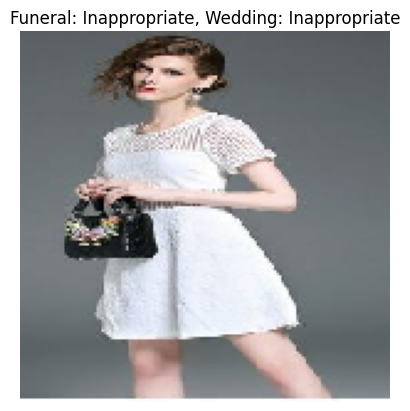

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


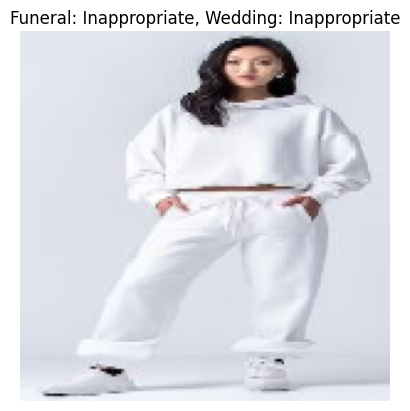

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


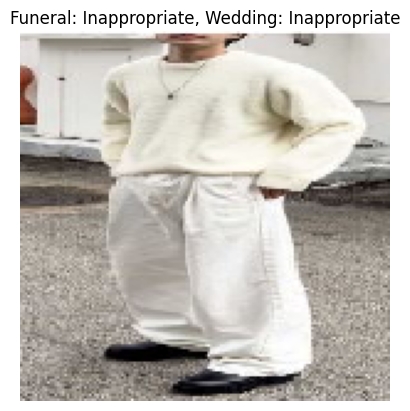

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


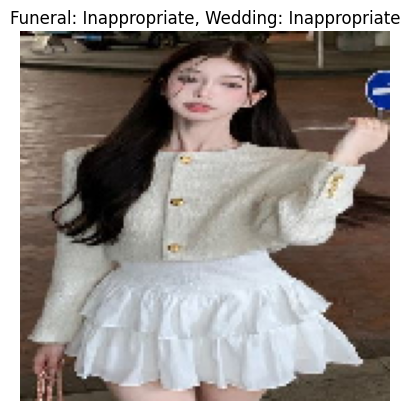

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


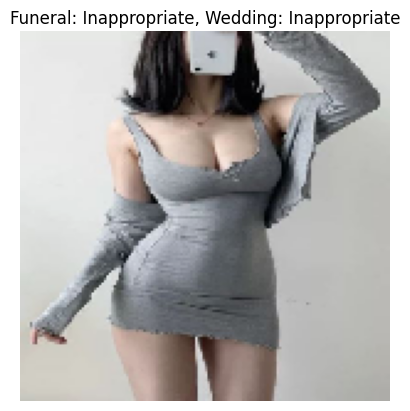

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


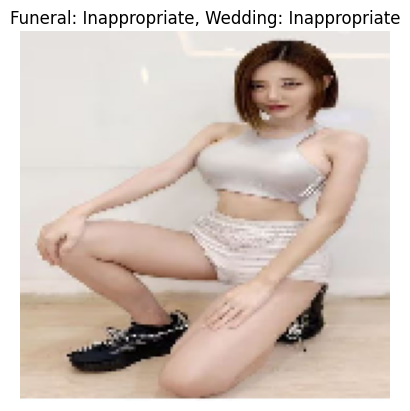

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


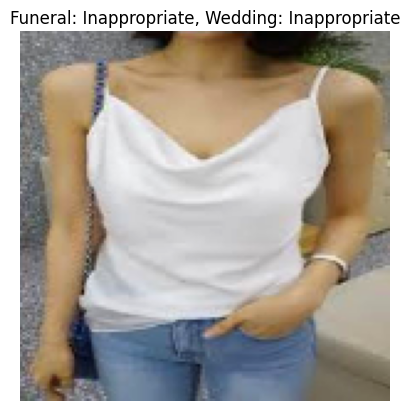

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


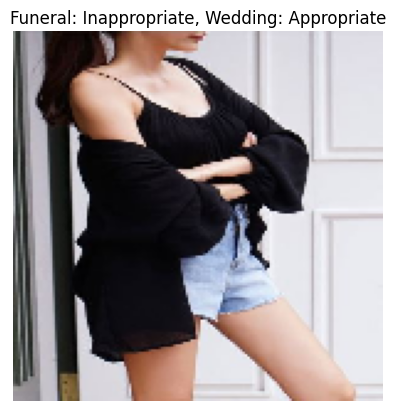

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


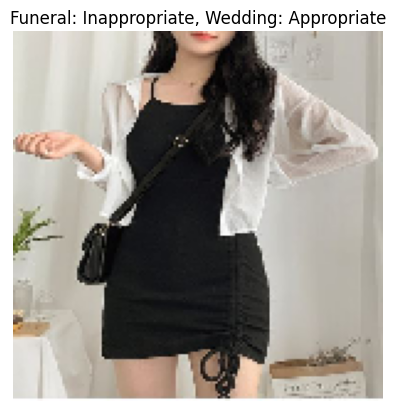

Funeral predictions: ['Inappropriate', 'Inappropriate', 'Inappropriate', 'Appropriate', 'Inappropriate', 'Appropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate']
Wedding predictions: ['Inappropriate', 'Appropriate', 'Inappropriate', 'Appropriate', 'Appropriate', 'Appropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Inappropriate', 'Appropriate', 'Appropriate']


In [14]:
funeral_predictions = []
wedding_predictions = []

for img_path in new_image_paths:
    if not os.path.exists(img_path):
        print(f'Skipping non-existent file: {img_path}')
        continue

    # 이미지 로드 및 전처리
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # 모델 학습 시 rescale=1./255을 적용했기 때문에 동일하게 전처리

    # 장례식 모델로 예측
    funeral_pred = funeral_model.predict(img_array)
    funeral_label = 'Appropriate' if funeral_pred > 0.5 else 'Inappropriate'
    funeral_predictions.append(funeral_label)

    # 결혼식 모델로 예측
    wedding_pred = wedding_model.predict(img_array)
    wedding_label = 'Appropriate' if wedding_pred > 0.5 else 'Inappropriate'
    wedding_predictions.append(wedding_label)

    # 이미지와 예측 결과를 출력
    plt.figure()
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title(f'Funeral: {funeral_label}, Wedding: {wedding_label}')
    plt.axis('off')
    plt.show()

print('Funeral predictions:', funeral_predictions)
print('Wedding predictions:', wedding_predictions)

In [16]:
import pickle

data_to_save = {"example_key": "example_value"}

file_path = './drive/MyDrive/Colab Notebooks/contest/data_outfit/data.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Pickle file saved at {file_path}")


Pickle file saved at ./drive/MyDrive/Colab Notebooks/contest/data_outfit/data.pkl
